In [1]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/manuel/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Load Data from Folders


In [2]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../"):
    for name in dirs:
        directories.append(os.path.join(root, name))

for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if ".csv" not in file:
            continue

        file_type = file.split("_")[1]

        print(f"Processing {file}")

        run = directory.split("/")[-2]
        factor = directory.split("/")[-1]
        scenario = "explodingLiquid"


        with open(os.path.join(directory, file)) as f:
            print(directory, file)
            content = f.read()
            df_tuners = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not run in data[scenario]:
            data[scenario][run] = {}

        if not factor in data[scenario][run]:
            data[scenario][run][factor] = {}

        data[scenario][run][factor][file_type] = df_tuners

Processing AutoPas_tuningResults_Rank0_pairwise_2025-02-01_23-33-11.csv
../explodingLiquid_1738449164.1206546/1.15 AutoPas_tuningResults_Rank0_pairwise_2025-02-01_23-33-11.csv
Processing AutoPas_tuningData_Rank0_pairwise_2025-02-01_23-33-11.csv
../explodingLiquid_1738449164.1206546/1.15 AutoPas_tuningData_Rank0_pairwise_2025-02-01_23-33-11.csv
Processing AutoPas_iterationPerformance_Rank0_2025-02-01_23-33-11.csv
../explodingLiquid_1738449164.1206546/1.15 AutoPas_iterationPerformance_Rank0_2025-02-01_23-33-11.csv
Processing AutoPas_tuningData_Rank0_pairwise_2025-02-01_23-33-08.csv
../explodingLiquid_1738449164.1206546/1.05 AutoPas_tuningData_Rank0_pairwise_2025-02-01_23-33-08.csv
Processing AutoPas_iterationPerformance_Rank0_2025-02-01_23-33-08.csv
../explodingLiquid_1738449164.1206546/1.05 AutoPas_iterationPerformance_Rank0_2025-02-01_23-33-08.csv
Processing AutoPas_tuningResults_Rank0_pairwise_2025-02-01_23-33-08.csv
../explodingLiquid_1738449164.1206546/1.05 AutoPas_tuningResults_Ran

# Make Line Plot of Smoothed Value over Iterations


In [3]:
def check_iterations_consistency(data):
    # Store reference iterations from first encountered data
    reference_iterations = None
    # Track which scenario/run/factor has mismatches
    mismatches = []

    for scenario, s_data in data.items():
        for run, r_data in s_data.items():
            for factor, logs in r_data.items():
                print(f"Checking {scenario}/{run}/{factor}")
                iteration_data = logs["iterationPerformance"]
                current_iterations = set(iteration_data["Iteration"])

                if reference_iterations is None:
                    reference_iterations = current_iterations
                    reference_count = len(reference_iterations)
                    print(f"Reference iteration count: {reference_count}")
                else:
                    current_count = len(current_iterations)
                    if current_iterations != reference_iterations:
                        mismatches.append({
                            'scenario': scenario,
                            'run': run,
                            'factor': factor,
                            'expected': reference_count,
                            'found': current_count,
                            'missing': reference_iterations - current_iterations,
                            'extra': current_iterations - reference_iterations
                        })

    # Report results
    if not mismatches:
        print("✓ All runs have consistent iteration counts")
        return True
    else:
        print("\n❌ Found inconsistencies in iteration counts:")
        for mismatch in mismatches:
            print(f"\nScenario: {mismatch['scenario']}")
            print(f"Run: {mismatch['run']}")
            print(f"Factor: {mismatch['factor']}")
            print(
                f"Expected {mismatch['expected']} iterations, found {mismatch['found']}")
            if mismatch['missing']:
                print(f"Missing iterations: {sorted(mismatch['missing'])}")
            if mismatch['extra']:
                print(f"Extra iterations: {sorted(mismatch['extra'])}")
        return False


all_consistent = check_iterations_consistency(data)
if not all_consistent:
    raise ValueError("Inconsistent iteration counts detected")

Checking explodingLiquid/explodingLiquid_1738449164.1206546/1.15
Reference iteration count: 12000
Checking explodingLiquid/explodingLiquid_1738449164.1206546/1.05
Checking explodingLiquid/explodingLiquid_1738449164.1206546/3
Checking explodingLiquid/explodingLiquid_1738449164.1206546/2.5
Checking explodingLiquid/explodingLiquid_1738449164.1206546/5.5
Checking explodingLiquid/explodingLiquid_1738449164.1206546/6.5
Checking explodingLiquid/explodingLiquid_1738449164.1206546/4
Checking explodingLiquid/explodingLiquid_1738449164.1206546/1.25
Checking explodingLiquid/explodingLiquid_1738449164.1206546/1.2
Checking explodingLiquid/explodingLiquid_1738449164.1206546/3.5
Checking explodingLiquid/explodingLiquid_1738449164.1206546/8
Checking explodingLiquid/explodingLiquid_1738449164.1206546/5
Checking explodingLiquid/explodingLiquid_1738449164.1206546/1.5
Checking explodingLiquid/explodingLiquid_1738449164.1206546/2
Checking explodingLiquid/explodingLiquid_1738449164.1206546/4.5
Checking explo

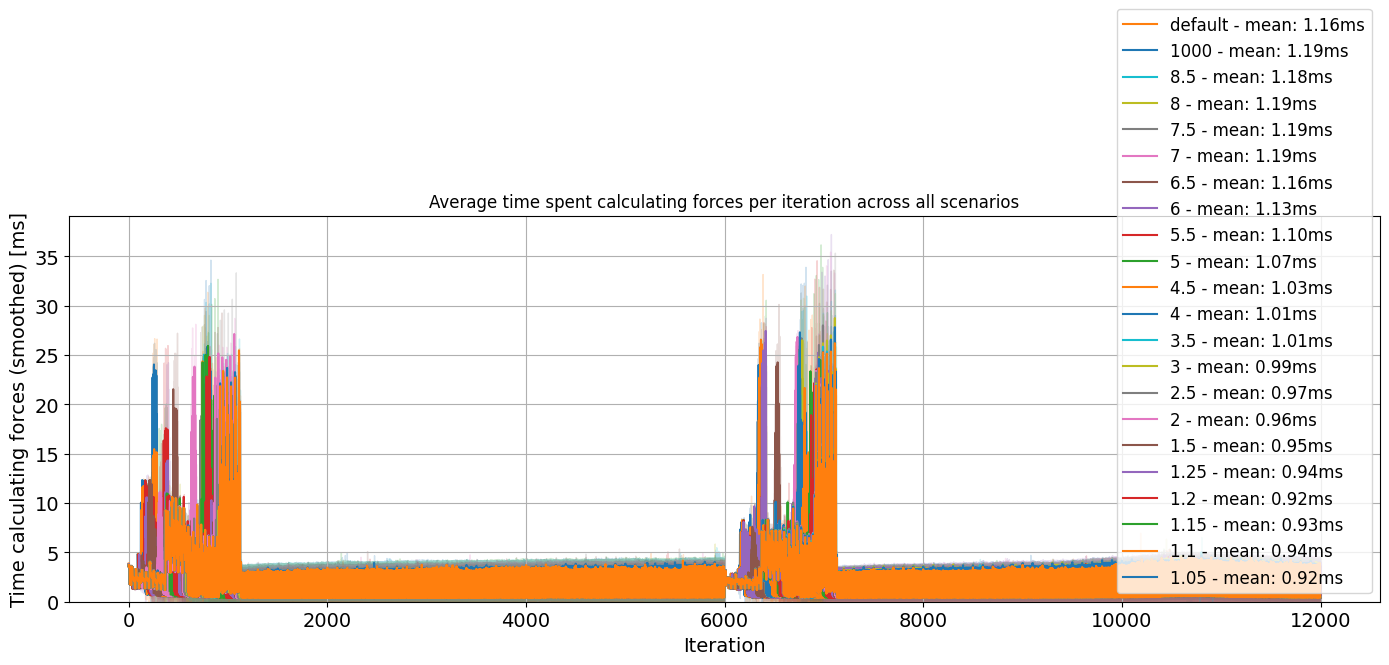

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from tsmoothie.smoother import ConvolutionSmoother


def plot_average_timeseries(data):
    # Helper function to convert factor to float
    def factor_to_float(factor):
        try:
            return float(factor)
        except ValueError:
            return float('inf')

    # Dictionary to store time series for each factor
    factor_series = {}

    # First pass: collect all time series and determine max common length
    min_length = float('inf')
    for scenario, s_data in data.items():
        for run, r_data in s_data.items():
            for factor, logs in r_data.items():
                iteration_data = logs["iterationPerformance"]
                # Convert to ms
                time_s = iteration_data["computeInteractionsTotal[ns]"] / 1e9 * 1000

                if factor not in factor_series:
                    factor_series[factor] = []

                factor_series[factor].append(time_s.values)
                min_length = min(min_length, len(time_s))

    # Truncate all series to minimum length and compute statistics
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))

    # Sort factors numerically, with non-numeric at end
    sorted_factors = sorted(factor_series.keys(), key=factor_to_float)

    # Store lines and labels for legend sorting
    lines = []
    labels = []

    for factor in sorted_factors:
        # Truncate and stack all series for this factor
        series_array = np.vstack([series[:min_length]
                                 for series in factor_series[factor]])

        # Compute mean series
        mean_series = np.mean(series_array, axis=0)

        # Smooth the mean series
        smoother = ConvolutionSmoother(window_len=2, window_type='blackman')
        smoother.smooth(mean_series)
        smoothed_data = smoother.smooth_data[0]

        # Compute confidence intervals and ensure they're non-negative
        std_series = np.std(series_array, axis=0)
        # Clip lower bound at 0
        low = np.maximum(0, smoothed_data - std_series)
        up = smoothed_data + std_series

        # Plot
        x = range(len(mean_series))
        line = ax.plot(smoothed_data,
                       label=f"{factor} - mean: {np.mean(mean_series):.2f}ms")[0]
        ax.fill_between(x, low, up, alpha=0.2, color=line.get_color())

        # Store line and label for legend sorting
        lines.append(line)
        labels.append(f"{factor} - mean: {np.mean(mean_series):.2f}ms")

    # Sort legend entries
    def sort_key(pair):
        factor = pair[1].split(' - ')[0]  # Extract factor from label
        try:
            return (0, float(factor))  # Numeric factors first, sorted by value
        except ValueError:
            # Non-numeric factors last, sorted alphabetically
            return (1, factor)

    # Sort lines and labels together
    pairs = sorted(zip(lines, labels), key=sort_key, reverse=True)
    sorted_lines, sorted_labels = zip(*pairs)

    # Customize plot
    plt.grid(True)
    ax.legend(sorted_lines, sorted_labels, prop={'size': 12})
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Time calculating forces (smoothed) [ms]")
    ax.set_title(
        "Average time spent calculating forces per iteration across all scenarios")

    # Set y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Adjust tick sizes
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.label.set_size(14)
    ax.xaxis.label.set_size(14)

    fig.tight_layout()

    # Save the figure
    fig.savefig("timing_average.png", dpi=300)

    return fig, ax


# Usage:
fig, ax = plot_average_timeseries(data)
plt.show()  # If you want to display the plot

# Make bar plots about total time

         Total Time [s]  Relative Time
1.05          10.988383       0.788680
1.1           11.334260       0.813505
1.15          11.132528       0.799025
1.2           10.998051       0.789374
1.25          11.276841       0.809383
1.5           11.376682       0.816549
2             11.540378       0.828298
2.5           11.681188       0.838405
3             11.839792       0.849789
3.5           12.060609       0.865637
4             12.159798       0.872757
4.5           12.416645       0.891192
5             12.852995       0.922510
5.5           13.173814       0.945537
6             13.522964       0.970596
6.5           13.901430       0.997760
7             14.267519       1.024036
7.5           14.255235       1.023154
8             14.220797       1.020683
8.5           14.180686       1.017804
1000          14.243687       1.022326
default       13.932633       1.000000


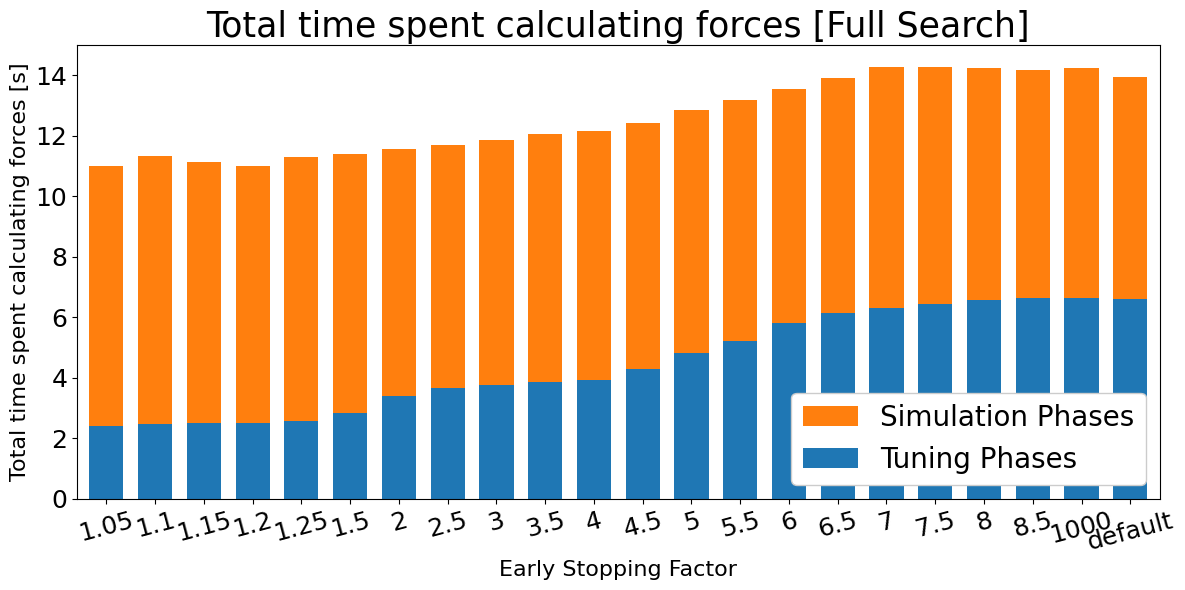

In [11]:

def plot_average_timings(data):
    # Initialize lists to store all timing data
    all_timings = []

    # Helper function to convert factor to float if possible
    def factor_to_float(factor):
        try:
            return float(factor)
        except ValueError:
            # Non-numeric factors will be placed at the end
            return float('inf')

    # Collect timings from all scenarios and runs
    for scenario, s_data in data.items():
        for run, r_data in s_data.items():
            timing_dict = {}

            # Sort factors numerically when possible
            sorted_factors = sorted(
                r_data.items(), key=lambda x: factor_to_float(x[0]))

            for factor, logs in sorted_factors:
                iteration_data = logs["iterationPerformance"]

                tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
                simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

                tuning_time_s = tuning_iterations["computeInteractionsTotal[ns]"].sum(
                ) / 1e9
                simulation_time_s = simulation_iterations["computeInteractionsTotal[ns]"].sum(
                ) / 1e9

                timing_dict[factor] = {
                    "Tuning Phases": tuning_time_s,
                    "Simulation Phases": simulation_time_s
                }

            # Convert to DataFrame and add to list
            df = pd.DataFrame(timing_dict).T
            all_timings.append(df)

    # Combine all DataFrames and calculate mean
    combined_df = pd.concat(all_timings)
    average_df = combined_df.groupby(combined_df.index).mean()

    # Sort the final DataFrame
    numeric_indices = pd.to_numeric(average_df.index.map(factor_to_float))
    average_df = average_df.iloc[numeric_indices.argsort()]

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    average_df.plot(kind='bar', stacked=True, ax=ax, width=0.7)

    plt.xticks(rotation=15, fontsize=16)
    ax.set_ylabel("Total time spent calculating forces [s]", fontsize=16)
    ax.set_xlabel("Early Stopping Factor", fontsize=16)

    ax.set_title(
        "Total time spent calculating forces [Full Search]", fontsize=25)

    # Reverse legend order for better visualization
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], prop={'size': 20}, loc='lower right',framealpha=1)

    # Adjust tick sizes
    ax.yaxis.set_tick_params(labelsize=18)
    ax.xaxis.set_tick_params(labelsize=18)

    fig.tight_layout()

    # set y lim

    # Save the figure
    fig.savefig("total_time_average.png", dpi=300)

    # make new table with total time and relative time
    total_time = average_df.sum(axis=1)
    relative_time = total_time /( total_time["default"] if "default" in total_time else 1)

    # Save the table
    table = pd.concat([total_time, relative_time], axis=1)
    table.columns = ["Total Time [s]", "Relative Time"]

    print(table)

    return fig, ax


# Usage:
fig, ax = plot_average_timings(data)
plt.show()  # If you want to display the plot

In [6]:
# Function to add jittered points
def add_jittered_points(data, pos, color, alpha=0.2, vert=True):
    y = data
    x = np.random.normal(pos, 0.1, size=len(y))

    if vert:
        plt.scatter(x, y, color=color, alpha=alpha)
    else:
        plt.scatter(y, x, color=color, alpha=alpha)

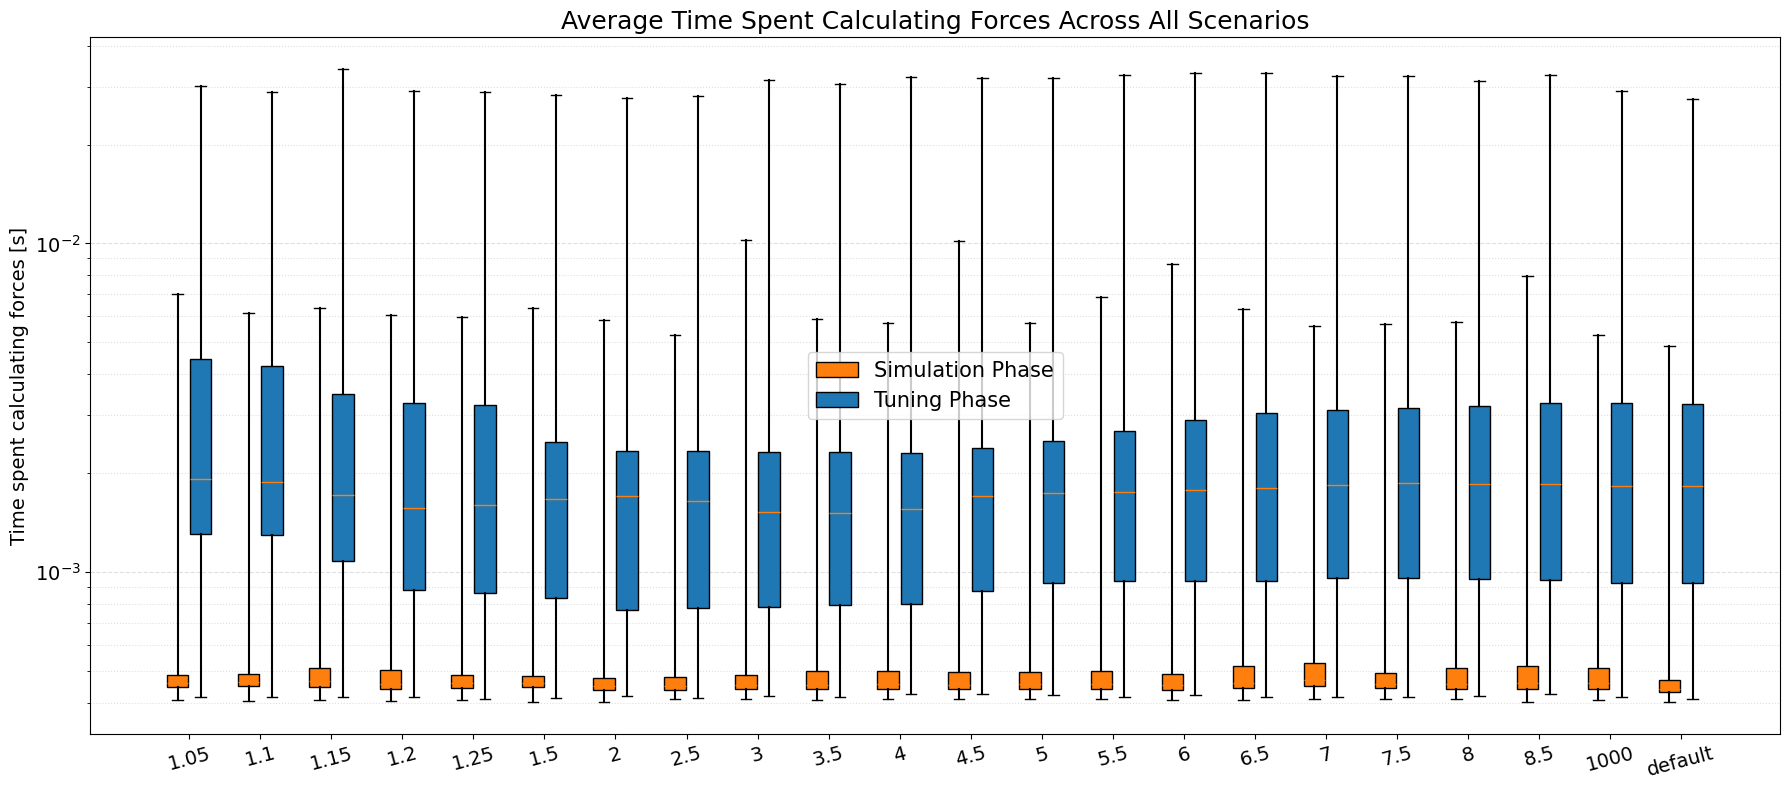

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def create_average_boxplot(data):
    # Dictionary to store combined timings across all scenarios and runs
    combined_timings = {}
    all_factors = set()

    # First pass: collect all factors and their timing data
    for scenario, s_data in data.items():
        for run, r_data in s_data.items():
            for factor, logs in sorted(r_data.items(), key=lambda x: float(x[0]) if x[0].replace(".", "").isdigit() else float("inf")):
                all_factors.add(factor)
                if factor not in combined_timings:
                    combined_timings[factor] = {
                        "Tuning Phases": [],
                        "Simulation Phases": []
                    }
                
                iteration_data = logs["iterationPerformance"]
                tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
                simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]
                
                combined_timings[factor]["Tuning Phases"].extend(tuning_iterations["computeInteractionsTotal[ns]"] / 1e9)
                combined_timings[factor]["Simulation Phases"].extend(simulation_iterations["computeInteractionsTotal[ns]"] / 1e9)

    # Create single plot
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # Sort factors for consistent plotting
    factors = sorted(all_factors, key=lambda x: float(x) if x.replace(".", "").isdigit() else float("inf"))
    
    # Set positions for boxplots
    positions = range(0, len(factors) * 4, 4)
    width = 1.2

    # Create boxplots with combined data
    bp_tuning = ax.boxplot([combined_timings[factor]["Tuning Phases"] for factor in factors],
                          positions=[p + width/2+0.05 for p in positions],
                          widths=width, patch_artist=True, 
                          flierprops=dict(marker='o', markersize=5, alpha=0.5),
                          whis=10000)

    bp_simulation = ax.boxplot([combined_timings[factor]["Simulation Phases"] for factor in factors],
                             positions=[p - width/2-0.05 for p in positions],
                             widths=width, patch_artist=True,
                             flierprops=dict(marker='o', markersize=5, alpha=0.5),
                             whis=10000)

    # Styling
    plt.title('Average Time Spent Calculating Forces Across All Scenarios', fontsize=18)
    ax.set_ylabel('Time spent calculating forces [s]', fontsize=16)
    
    # Colors and appearance
    for box in bp_tuning['boxes']:
        box.set(facecolor='#1f77b4')
    for box in bp_simulation['boxes']:
        box.set(facecolor='#ff7f0e')

    # Make whiskers bold
    for whisker in bp_tuning['whiskers']:
        whisker.set_linewidth(1.5)
    for whisker in bp_simulation['whiskers']:
        whisker.set_linewidth(1.5)

    # X-axis settings
    ax.set_xticks(positions)
    ax.set_xticklabels(factors, rotation=15)

    # Grid settings
    ax.yaxis.grid(True, linestyle=':', which='minor', color='grey', alpha=.25)
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

    # Legend
    ax.legend([bp_simulation["boxes"][0], bp_tuning["boxes"][0]],
             ["Simulation Phase", "Tuning Phase"], fontsize=15)

    # Scale and ticks
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.label.set_size(14)

    # Layout and save
    fig.tight_layout()
    fig.savefig("average_boxplot.png", dpi=300)
    
    return fig, ax

# Usage:
fig, ax = create_average_boxplot(data)
plt.show()

In [8]:
# Function to add jittered points
def add_jittered_points(data, pos, color, alpha=0.2, vert=True):
    y = data
    x = np.random.normal(pos, 0.1, size=len(y))

    if vert:
        plt.scatter(x, y, color=color, alpha=alpha)
    else:
        plt.scatter(y, x, color=color, alpha=alpha)


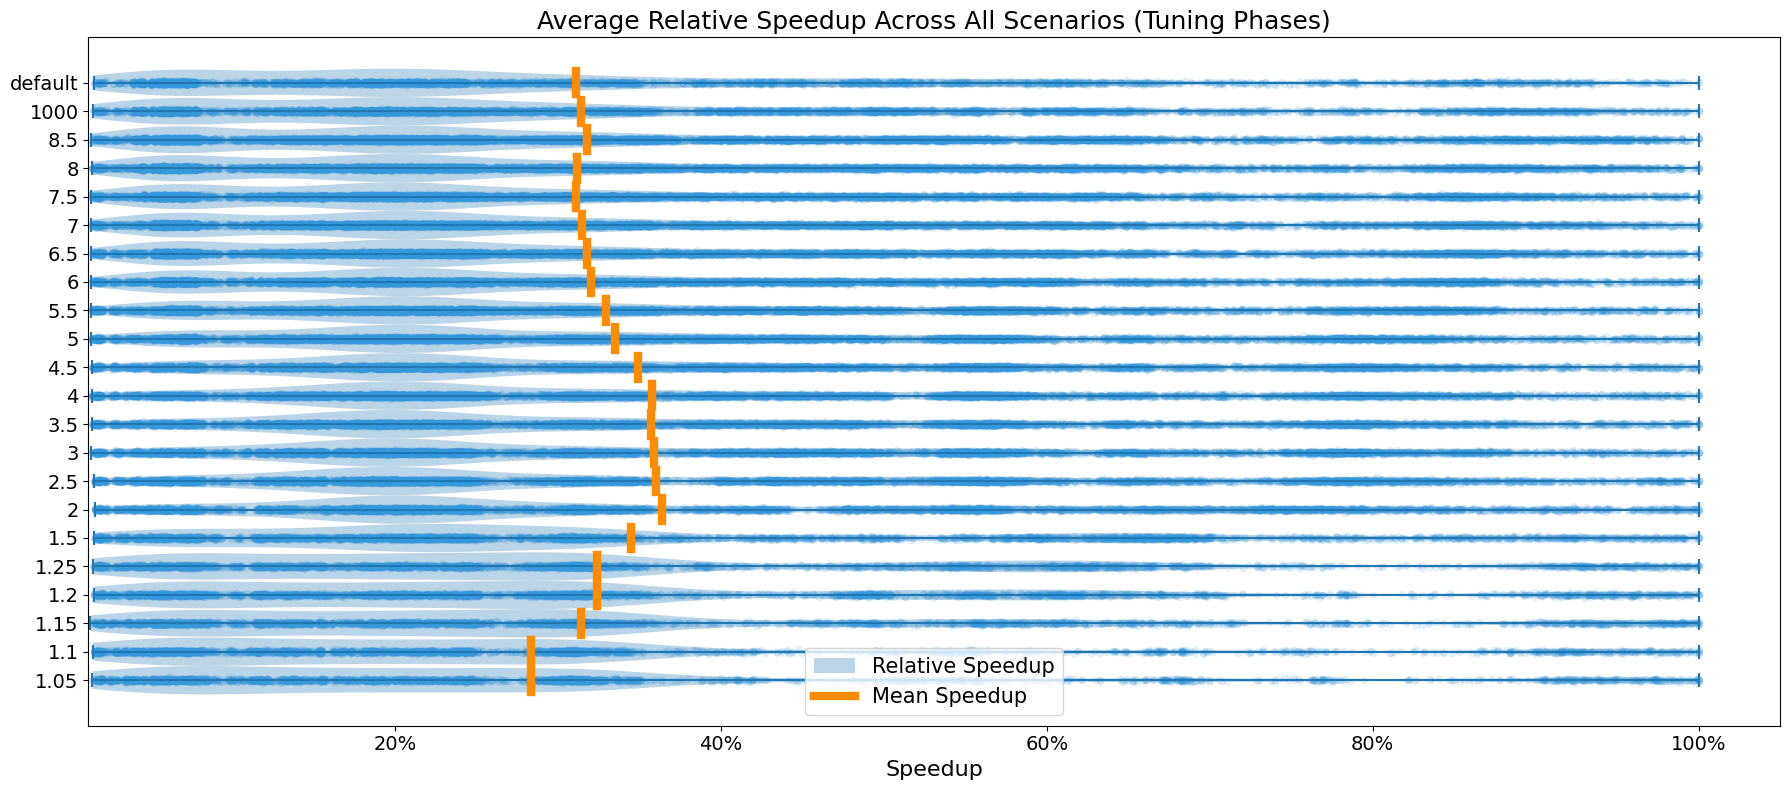

In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd

def add_jittered_points(data, pos, color, vert=True, alpha=0.5):
    spread = 0.3
    if vert:
        y = data
        x = np.random.normal(pos, spread * 0.1, size=len(data))
        plt.scatter(x, y, c=color, alpha=alpha, s=20)
    else:
        x = data
        y = np.random.normal(pos, spread * 0.1, size=len(data))
        plt.scatter(x, y, c=color, alpha=alpha, s=20)

def create_combined_speedup_plot(data):
    # Dictionary to store combined speedups across all scenarios and runs
    combined_speedups = {}
    all_factors = set()
    min_speedup = 1

    def calc_speedup(x): return x.min() / x

    # First pass: collect all factors and their speedup data
    for scenario, s_data in data.items():
        for run, r_data in s_data.items():
            for factor, logs in sorted(r_data.items(), key=lambda x: float(x[0]) if x[0].replace(".", "").isdigit() else float("inf")):
                all_factors.add(factor)
                if factor not in combined_speedups:
                    combined_speedups[factor] = []
                
                iteration_data = logs["iterationPerformance"]
                tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
                speedup = calc_speedup(tuning_iterations["computeInteractionsTotal[ns]"])
                combined_speedups[factor].extend(speedup)
                min_speedup = min(min_speedup, min(speedup))

    # Sort factors for consistent plotting
    factors = sorted(list(all_factors), key=lambda x: float(x) if x.replace(".", "").isdigit() else float("inf"))

    # Create plot
    fig, ax = plt.subplots(figsize=(18, 8))

    # Plot settings
    positions = range(0, len(factors))
    width = 1

    # Create violin plot with combined data
    bp_tuning = ax.violinplot([combined_speedups[factor] for factor in factors],
                             positions=positions,
                             widths=width, 
                             vert=False)

    # Add jittered points
    for i, factor in enumerate(factors):
        add_jittered_points(
            np.array(combined_speedups[factor]), 
            positions[i], 
            '#3498db', 
            vert=False, 
            alpha=0.1
        )

    # Add mean lines
    for i, factor in enumerate(factors):
        mean = np.mean(combined_speedups[factor])
        ax.plot([mean, mean], 
                [positions[i] - 0.4, positions[i] + 0.4],
                color='darkorange', 
                linewidth=6)

    # Styling
    plt.title('Average Relative Speedup Across All Scenarios (Tuning Phases)', 
             fontsize=18)
    ax.set_xlabel('Speedup', fontsize=16)

    # Colors
    for violin in bp_tuning['bodies']:
        violin.set(facecolor='#1f77b4')

    # Ticks and labels
    ax.set_yticks(positions)
    ax.set_yticklabels(factors)

    # Grid
    ax.yaxis.grid(True, linestyle=':', which='minor', color='grey', alpha=.25)
    ax.xaxis.grid(True, linestyle='--', which='minor', color='grey', alpha=.25)

    # Legend
    ax.legend([bp_tuning["bodies"][0], Line2D([0], [0], color='darkorange', lw=6)],
              ["Relative Speedup", "Mean Speedup"], 
              fontsize=15)

    # Tick parameters
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.label.set_size(14)

    # Layout
    fig.tight_layout()

    # X-axis limits and formatting
    ax.set_xlim(min_speedup * 0.9, 1.05)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

    # Save
    fig.savefig("combined_tuning_phase_speedup.png", dpi=300)
    
    return fig, ax

# Usage:
fig, ax = create_combined_speedup_plot(data)
plt.show()

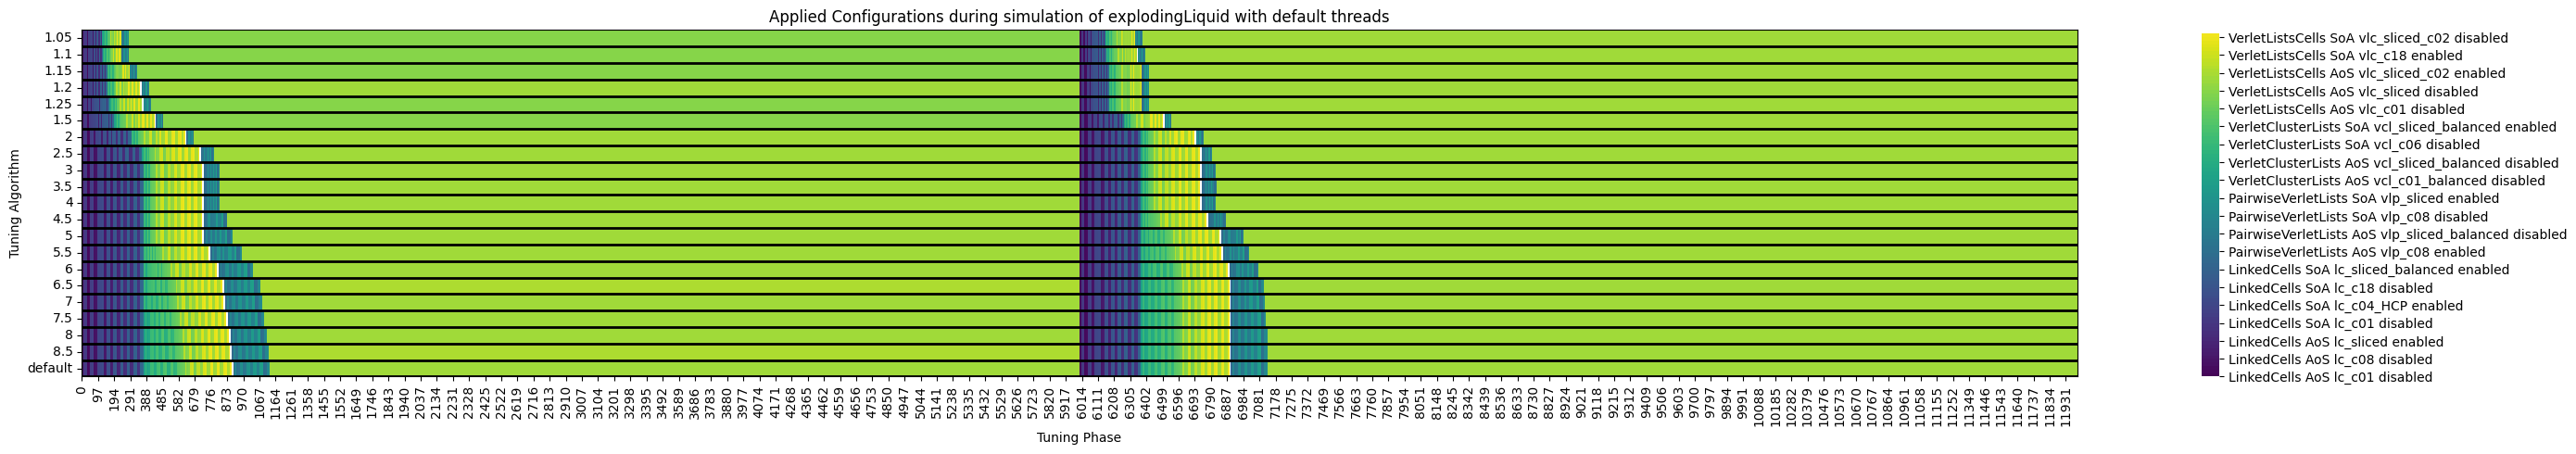

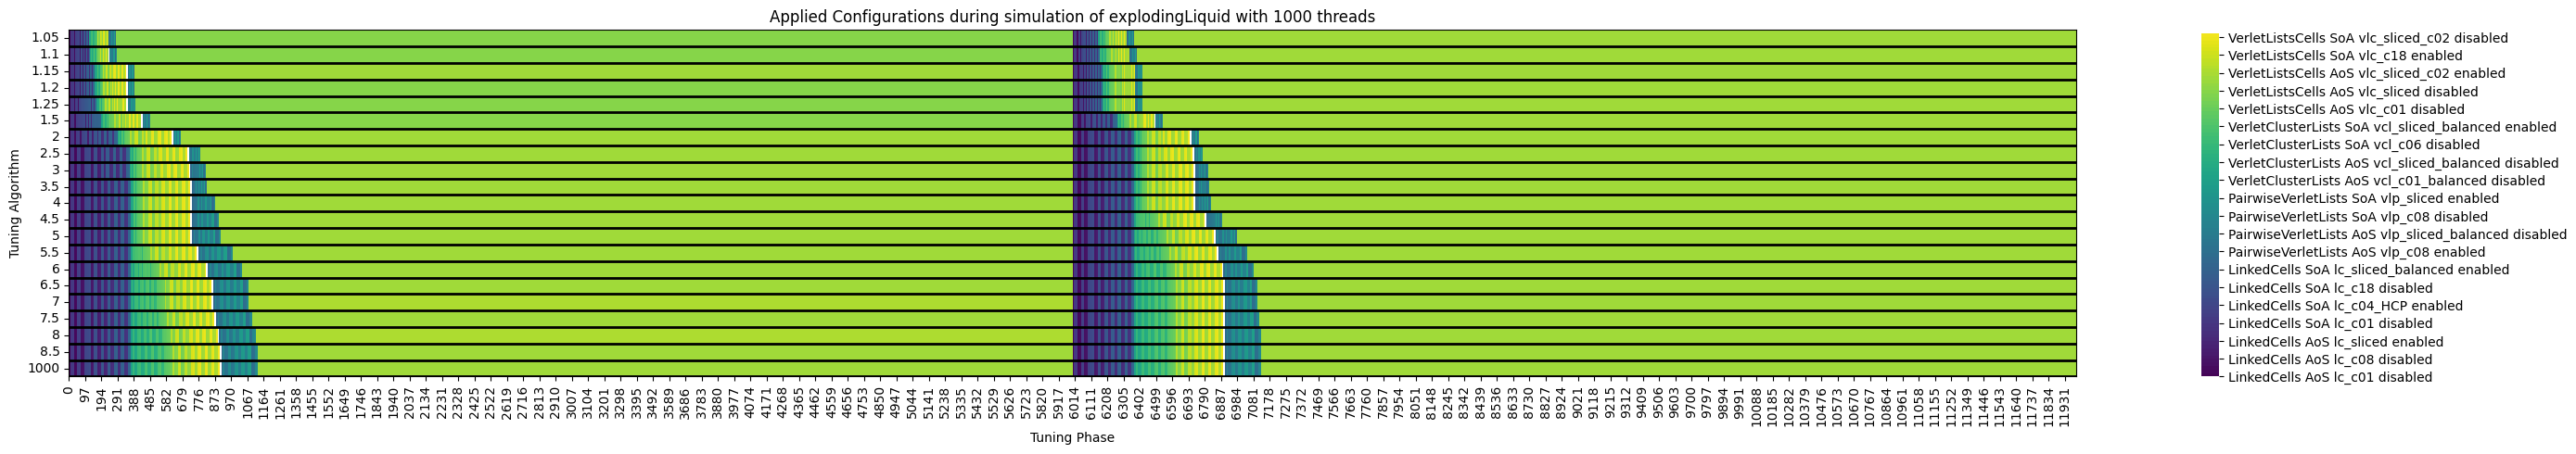

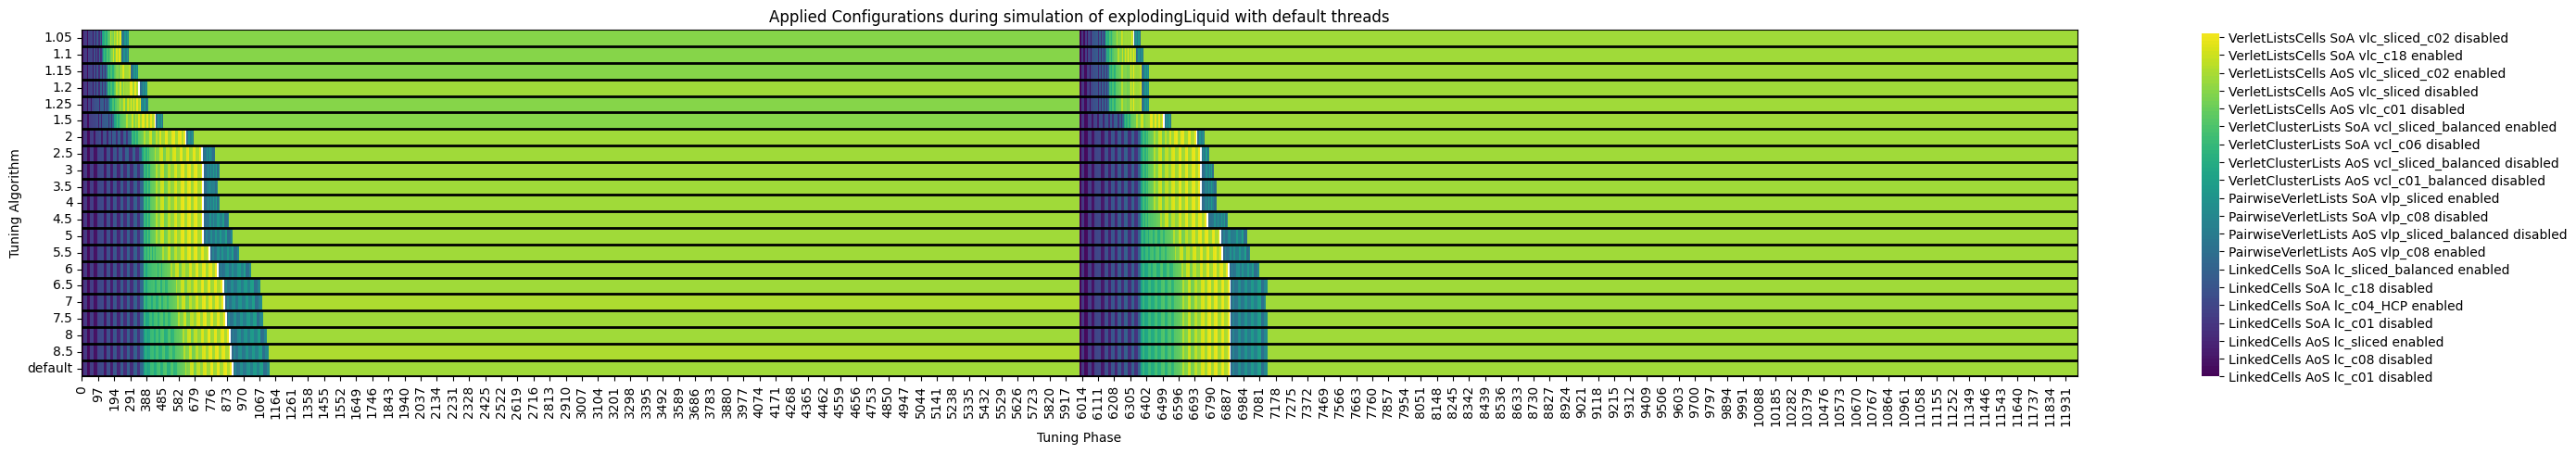

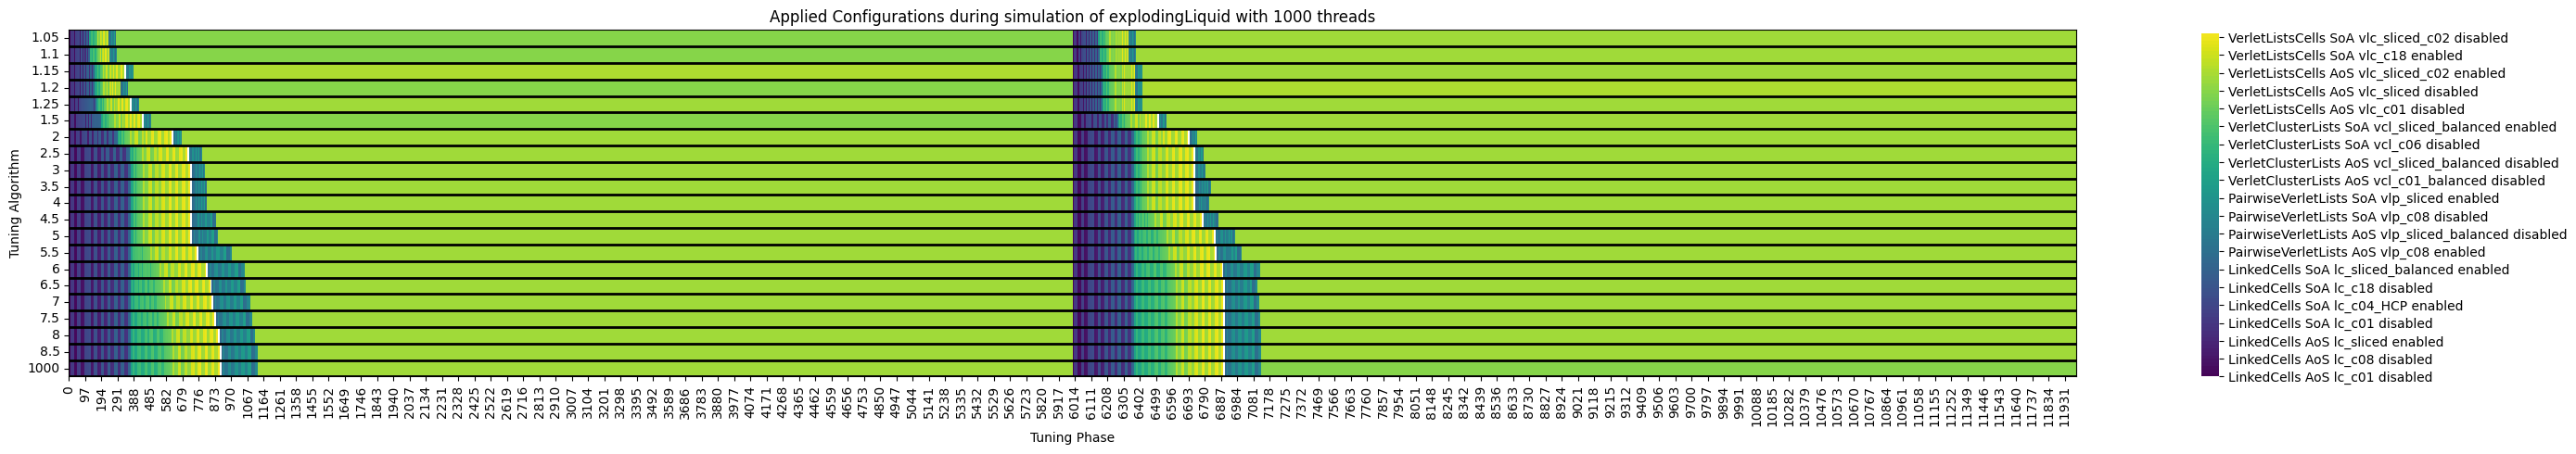

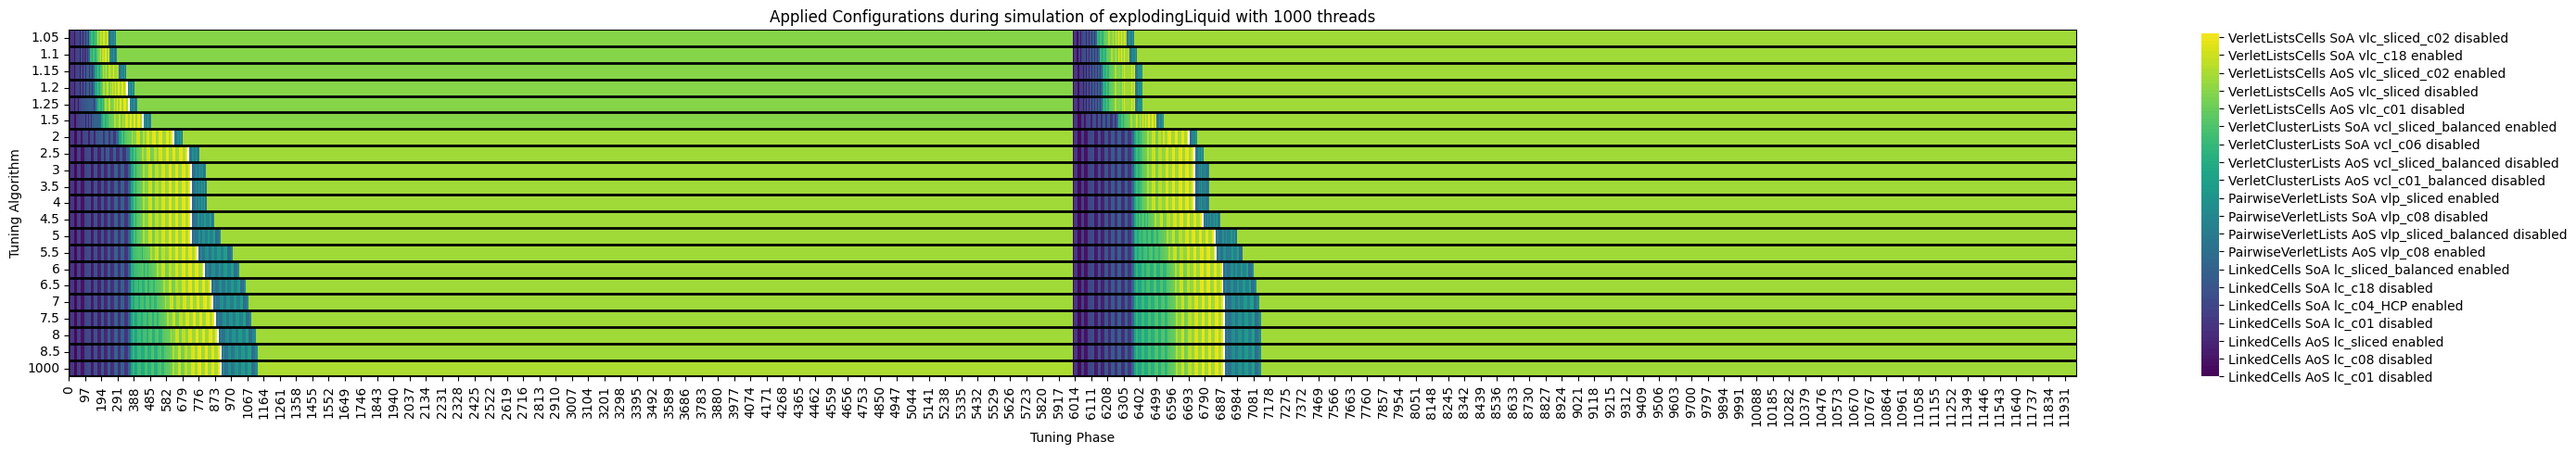

In [10]:
import numpy as np
# TODO FIX THIS. THE ITERATION IS NOT CORRECTLY ALIGNED

for scenario, s_data in data.items():
    for run, r_data in s_data.items():

        df_tuners = pd.DataFrame()

        fig, ax = plt.subplots(1, 1, figsize=(28, 5),tight_layout=True)

        for factor, logs in sorted(r_data.items(), key=lambda x: float(x[0]) if x[0].replace(".", "").isdigit() else float("inf")):
            tuning_results = logs["iterationPerformance"]

            iteration = tuning_results["Iteration"]
            container = tuning_results["Container"]
            datalayout = tuning_results["Data Layout"]
            traversal = tuning_results["Traversal"]
            newton3 = tuning_results["Newton 3"]

            combined = []
            for (i, iter) in iteration.items():

                comb = " ".join(
                    [str(container.iloc[i]), str(datalayout.iloc[i]), str(traversal.iloc[i]), str(newton3.iloc[i])])
                combined.append(comb)

            total_config = pd.DataFrame(
                combined, columns=[factor])

            df_tuners = pd.concat([df_tuners, total_config], axis=1)

        df = df_tuners

        # find nan values
        # replace nan values with "None"
        df = df.fillna("zzzzNone")

        value_to_int = {value: i for i, value in enumerate(
            sorted(pd.unique(df.values.ravel())))}
        value_to_int["zzzzNone"] = -1

        n = len(value_to_int)
        cmap = sns.color_palette("viridis", n)

        # color zzzzNone with white
        cmap[value_to_int["zzzzNone"]] = (1, 1, 1, 1)

        sns.heatmap(df.replace(value_to_int).T, cmap=cmap, ax=ax)

        colorbar = ax.collections[0].colorbar
        r = colorbar.vmax - colorbar.vmin

        # only show every k tick
        k = 5

        colorbar.set_ticks(
            [colorbar.vmin + r / (n-1) * i for i in range(0, n, k)])

        colorbar.set_ticklabels(
            [list(value_to_int.keys())[i] for i in range(0, n, k)])

        # legend below the heatmap

        ax.set_title(
            f"Applied Configurations during simulation of {scenario} with {factor} threads")
        ax.set_xlabel("Tuning Phase")
        ax.set_ylabel("Tuning Algorithm")

        # change x ticks to 2000 steps

        # set y label positon to the top left corner

        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

        # set rotation of y labels
        # move y ticks a bit to the left

        # draw horizontal lines
        for i in range(1, len(df.index)):
            ax.axhline(i, color="black", lw=2)

        plt.savefig(f"colorbar_{scenario}_{run}.png", dpi=300)
        plt.show()


        # fig.savefig(f"heatmap_{scenario}_{thread}.png", dpi=300)